<a href="https://colab.research.google.com/github/abksyed/EVA4/blob/master/S5/EVA4_S5_Assignment_iter02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Statements

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Targets

**Overall Target to Acheive**
 

1.   99.4% (this must be consistently shown in your last few epochs, and not a one-time achievement)
2.   Less than or equal to 15 Epochs
3.   Less than 10000 Parameters

*Target Acheived in Last Iteration*

1.   Parameters Used: **7474**
1.   Test Accuracy: **99.1%**
2.   Training Accuracy: **100%**
2.   Epochs Used: **15**

*Target for this Iteration:*


1.   Improve the Model
2.   Add Batch Normalization to increase model effeciency

#Raw Data Statistics

In [0]:
#Getting to know Data
data = datasets.MNIST('./data', train= True, transform= transforms.Compose([transforms.ToTensor(),]), download= True)

exp = data.data
exp = data.transform(exp.numpy())

print('Train Statistics')
print(' - Numpy Shape:', data.data.cpu().numpy().shape)
print(' - Tensor Shape:', data.data.size())
print(' - min:', torch.min(exp))
print(' - max:', torch.max(exp))
print(' - mean:', torch.mean(exp))
print(' - std:', torch.std(exp))
print(' - var:', torch.var(exp))

Train Statistics
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1305)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


#Transforming Raw Data to Normalized Data

In [0]:
#Transforming Data (Normalizing to mean=1, std= 0)
train_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1311,), (0.3081,))
]
)

test_transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.1311,),(0.3081,))
])

#Creating Train/Test Split

In [0]:
#Getting Train and Test Data
train = datasets.MNIST('./data', train= True, transform= train_transform)
test = datasets.MNIST('./data', train= False, transform= test_transform)

#Dataloader Arguments & Test/Train Dataloaders

In [0]:
seed = 1

#CUDA Availability
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

#For Reproducibility
torch.manual_seed(seed)

if cuda:
    torch.cuda.manual_seed(seed)

dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory= True) if cuda else dict(shuffle= True, batch_size=64)

#Train Dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

#Test Dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: torch.Size([28, 60000, 28])
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4255)
 - max: tensor(2.8202)
 - mean: tensor(0.0004)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([64, 1, 28, 28])
torch.Size([64])


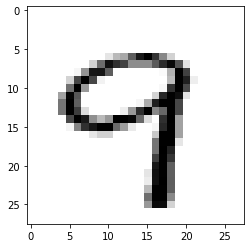

In [0]:
#Testing Normalized Data Statistics

train_numpy = train.train_data
train_numpy = train.transform(train_numpy.numpy())

print('[Train]')
print(' - Numpy Shape:', train_numpy.shape)
print(' - Tensor Shape:', train.data.size())
print(' - min:', torch.min(train_numpy))
print(' - max:', torch.max(train_numpy))
print(' - mean:', torch.mean(train_numpy))
print(' - std:', torch.std(train_numpy))
print(' - var:', torch.var(train_numpy))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

#Viewing Sample Images in Dataset

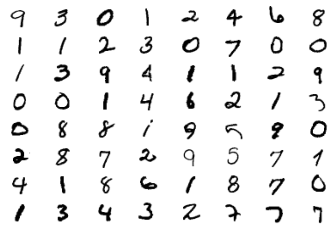

In [0]:
figure = plt.figure()
num_of_images = 64
for index in range(0, num_of_images):
    plt.subplot(8, 8, index+1)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

#**THE MODEL**

In [0]:
class Net(nn.Module):

  def __init__(self):

    super(Net, self).__init__()

    #Input Block - Input= 28
    self.block1 = nn.Sequential(
        nn.Conv2d(in_channels= 1, out_channels= 8, kernel_size= 3, padding= 1, bias= False),
        nn.BatchNorm2d(8),
        nn.ReLU()
    ) #Output= 28 / ReceptiveField= 3

    #Convolution Block - Input= 28
    self.block2 = nn.Sequential(
        nn.Conv2d(in_channels= 8, out_channels= 8, kernel_size= 3, padding= 1, bias= False),
        nn.BatchNorm2d(8),
        nn.ReLU()
    ) #Output= 28 / ReceptiveField= 5

    #Max Pooling and 1x1 Convolution
    self.mp1 = nn.Sequential(
        nn.MaxPool2d(2),
        #nn.Conv2d(in_channels= 16, out_channels= 8, kernel_size= 1, bias= False)
    )#Output= 14 / ReceptiveField= 6

    #Convolution Block - Input= 14
    self.block3 = nn.Sequential(
        nn.Conv2d(in_channels= 8, out_channels= 16, kernel_size= 3, padding= 1, bias= False),
        nn.BatchNorm2d(16),
        nn.ReLU(), 
        #Output= 14 / ReceptiveField= 10
        nn.Conv2d(in_channels= 16, out_channels= 16, kernel_size= 3, padding= 1, bias= False),
        nn.BatchNorm2d(16),
        nn.ReLU()
    ) #Output= 14 / ReceptiveField= 14

    #Max Pooling and 1x1 Convolution
    self.mp2 = nn.Sequential(
        nn.MaxPool2d(2),
        nn.Conv2d(in_channels= 16, out_channels= 8, kernel_size= 1, bias= False),
        nn.BatchNorm2d(8)
    )#Output= 7 / ReceptiveField= 16    

    #Convolution Block - Input= 7
    self.block4 = nn.Sequential(
        nn.Conv2d(in_channels= 8, out_channels= 20, kernel_size= 3, padding= 0, bias= False),
        nn.BatchNorm2d(20),
        nn.ReLU(), 
        #Output= 5 / ReceptiveField= 24
        nn.Conv2d(in_channels= 20, out_channels= 10, kernel_size= 3, padding= 0, bias= False)
    ) #Output= 3 / ReceptiveField= 32

    #GAP - Input 3
    self.gap = nn.AvgPool2d(3)
    #Output= 1 / ReceptiveField= 32

  def forward(self,x):

     x = self.block1(x)
     x = self.block2(x)
     x = self.mp1(x)
     x = self.block3(x)
     x = self.mp2(x)
     x = self.block4(x)
     x = self.gap(x)
     x = x.view(-1,10)

     return F.log_softmax(x, dim=-1)

#Inspecting Model Parameters

In [0]:
!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
       BatchNorm2d-2            [-1, 8, 28, 28]              16
              ReLU-3            [-1, 8, 28, 28]               0
            Conv2d-4            [-1, 8, 28, 28]             576
       BatchNorm2d-5            [-1, 8, 28, 28]              16
              ReLU-6            [-1, 8, 28, 28]               0
         MaxPool2d-7            [-1, 8, 14, 14]               0
            Conv2d-8           [-1, 16, 14, 14]           1,152
       BatchNorm2d-9           [-1, 16, 14, 14]              32
             ReLU-10           [-1, 16, 14, 14]               0
           Conv2d-11           [-1, 16, 14, 14]           2,304
      BatchNorm2d-12           [-1, 16, 14, 14]              32
             ReLU-13           [-1, 16, 14, 14]               0
        MaxPool2d-14             [

#Training and Testing

In [0]:
from tqdm import tqdm

train_loss = []
test_loss = []

train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()

    y_pred = model(data)

    loss = F.nll_loss(y_pred, target)
    train_loss.append(loss)

    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim= True)
    correct+= pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100 * correct/processed)

In [0]:
def test(model, device, test_loader):
  model.eval()
  correct= 0
  tloss= 0

  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)

      output = model(data)

      tloss+= F.nll_loss(output, target, reduction= 'sum').item()
      pred= output.argmax(dim= 1, keepdim= True)
      correct+= pred.eq(target.view_as(pred)).sum().item()

  tloss /= len(test_loader.dataset)
  test_loss.append(tloss)
  print(100 * correct/len(test_loader.dataset))
  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        tloss, correct, len(test_loader.dataset),
        100 * correct/len(test_loader.dataset)))
  
  test_acc.append(100 * correct/len(test_loader.dataset))

#Running the Model

In [0]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr= 0.01, momentum= 0.9)
epochs = 15

for epoch in range(epochs):
  print('EPOCH: ', epoch+1)
  train(model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH:  1


Loss=0.12385239452123642 Batch_id=937 Accuracy=94.33: 100%|██████████| 938/938 [00:13<00:00, 69.37it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

98.22

Test set: Average loss: 0.0558, Accuracy: 9822/10000 (98.22%)

EPOCH:  2


Loss=0.015000894665718079 Batch_id=937 Accuracy=98.36: 100%|██████████| 938/938 [00:13<00:00, 70.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

98.36

Test set: Average loss: 0.0517, Accuracy: 9836/10000 (98.36%)

EPOCH:  3


Loss=0.009967207908630371 Batch_id=937 Accuracy=98.68: 100%|██████████| 938/938 [00:13<00:00, 67.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

98.64

Test set: Average loss: 0.0429, Accuracy: 9864/10000 (98.64%)

EPOCH:  4


Loss=0.01026219129562378 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:13<00:00, 68.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

99.1

Test set: Average loss: 0.0312, Accuracy: 9910/10000 (99.10%)

EPOCH:  5


Loss=0.0019902437925338745 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [00:13<00:00, 69.37it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

99.05

Test set: Average loss: 0.0323, Accuracy: 9905/10000 (99.05%)

EPOCH:  6


Loss=0.011774301528930664 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [00:13<00:00, 69.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

99.1

Test set: Average loss: 0.0310, Accuracy: 9910/10000 (99.10%)

EPOCH:  7


Loss=0.08514250814914703 Batch_id=937 Accuracy=99.24: 100%|██████████| 938/938 [00:13<00:00, 68.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

99.22

Test set: Average loss: 0.0276, Accuracy: 9922/10000 (99.22%)

EPOCH:  8


Loss=0.005152866244316101 Batch_id=937 Accuracy=99.22: 100%|██████████| 938/938 [00:13<00:00, 69.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

99.07

Test set: Average loss: 0.0297, Accuracy: 9907/10000 (99.07%)

EPOCH:  9


Loss=0.004778847098350525 Batch_id=937 Accuracy=99.33: 100%|██████████| 938/938 [00:13<00:00, 68.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

99.01

Test set: Average loss: 0.0321, Accuracy: 9901/10000 (99.01%)

EPOCH:  10


Loss=0.004258334636688232 Batch_id=937 Accuracy=99.35: 100%|██████████| 938/938 [00:13<00:00, 69.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

99.27

Test set: Average loss: 0.0239, Accuracy: 9927/10000 (99.27%)

EPOCH:  11


Loss=0.0008038133382797241 Batch_id=937 Accuracy=99.48: 100%|██████████| 938/938 [00:13<00:00, 69.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

99.24

Test set: Average loss: 0.0242, Accuracy: 9924/10000 (99.24%)

EPOCH:  12


Loss=0.04990145564079285 Batch_id=937 Accuracy=99.47: 100%|██████████| 938/938 [00:13<00:00, 70.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

99.16

Test set: Average loss: 0.0254, Accuracy: 9916/10000 (99.16%)

EPOCH:  13


Loss=0.13040809333324432 Batch_id=937 Accuracy=99.52: 100%|██████████| 938/938 [00:13<00:00, 68.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

99.2

Test set: Average loss: 0.0285, Accuracy: 9920/10000 (99.20%)

EPOCH:  14


Loss=0.03225328028202057 Batch_id=937 Accuracy=99.53: 100%|██████████| 938/938 [00:13<00:00, 68.92it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

99.27

Test set: Average loss: 0.0232, Accuracy: 9927/10000 (99.27%)

EPOCH:  15


Loss=0.03783833980560303 Batch_id=937 Accuracy=99.57: 100%|██████████| 938/938 [00:13<00:00, 69.11it/s]


99.21

Test set: Average loss: 0.0225, Accuracy: 9921/10000 (99.21%)




Max Training Loss 2.35741925239563 with Max Training Accuracy 100.0

Max Testing Loss 0.0557795339345932 with Max Testing Accuracy 99.27


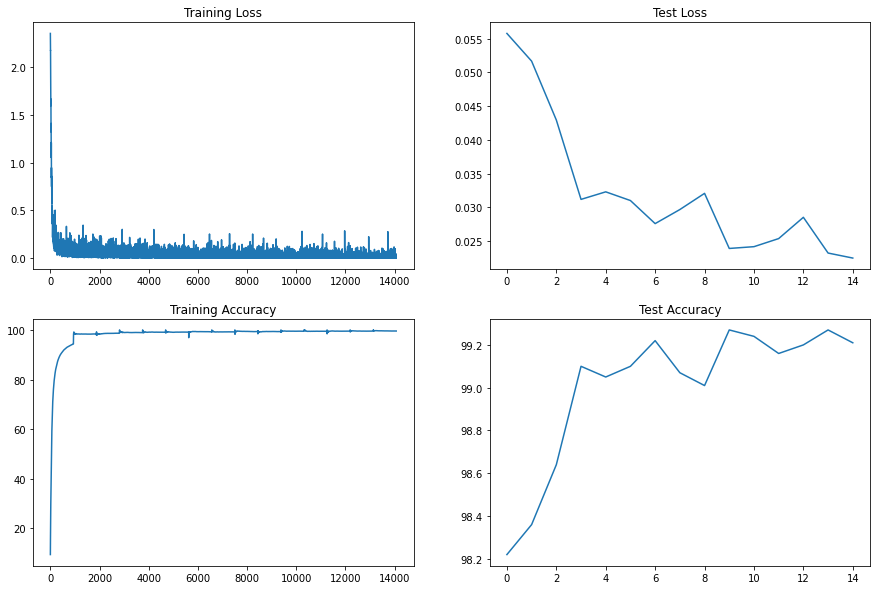

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_loss)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_loss)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

print()
print(f'Max Training Loss {max(train_loss)} with Max Training Accuracy {max(train_acc)}')
print()
print(f'Max Testing Loss {max(test_loss)} with Max Testing Accuracy {max(test_acc)}')

#Results:



1.   Parameters Used: **7624**
1.   Test Accuracy: **99.27%**
2.   Training Accuracy: **100%**
2.   Epochs Used: **15**



#Analysis:



1.   Over-fitting still exists, as Train accuracy has reached 100% and can't be increase futher, so no more scope for increase in Test Accuracy
2.   But the test accuracy has increased from 99.1 in previous iteration(without BatchNorm) to 99.27(with BatchNorm) 
3.   Number of Parameters used are 7624, so more 2400 parameters can be used if required.
4.   Need to reduce to Overfitting




